In [6]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs
sns.set_style('white')

workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/SEPT10'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir        = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'

In [7]:
def get_df(popname):
    df = pd.read_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname),index_col = 0)
    return df 

controls = get_df('controls')
patients = get_df('patients')


In [8]:
def cohen_d(df1,df2, metabolite):
    x = df1[metabolite].dropna(axis=0)
    y = df2[metabolite].dropna(axis=0)
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def grubbs_outliers(df, measure, alpha = 0.05):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def calc_confidence_95(df1,df2, metabolite):
    import numpy as np, statsmodels.stats.api as sms
    X1 = df1[metabolite].dropna(axis=0)
    X2 = df2[metabolite].dropna(axis=0)
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    return cm.tconfint_diff(usevar='pooled')


In [9]:

def make_statistical_comparison(df_controls, df_patients, stat, measures, grubbs = False, ESD = False):
    df_controls['Group'] = 0
    df_patients['Group'] = 1
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D','CI_95', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    if grubbs:
        for measure in measures:
            grubbs_controls = grubbs_outliers(df_controls, measure)
            grubbs_patients = grubbs_outliers(df_patients, measure)
            print 'GRUBBS OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
    elif ESD:
        for measure in measures:
            grubbs_controls = gESD_outliers(df_controls, measure)
            grubbs_patients = gESD_outliers(df_patients, measure)
            print 'gESD OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
        
    df = pd.concat([df_controls, df_patients])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Group + Age + Gender + EFC_MAG + QI1_MAG'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        ci95 = calc_confidence_95(df_controls, df_patients, measure)
        xval = 1
        npr  = 4
        dfs.ix['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure].dropna(), df_patients[measure].dropna())[1],5)
        dfs.ix['KS'][measure] = np.round(ks_2samp((df_controls[measure].dropna()), 
                                                  (df_patients[measure].dropna()))[1], 5)
        dfs.ix['KS_C'][measure] = np.round(kstest((df_controls[measure].dropna()), 'norm')[1],5)
        dfs.ix['KS_P'][measure] = np.round(kstest((df_patients[measure].dropna()), 'norm')[1],25)
        dfs.ix['D'][measure]    = cohen_d(df_controls, df_patients,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(df_controls, df_patients,measure),2)
        dfs.ix['CI_95'][measure]= '%s to %s'%(np.round(ci95[0],2), np.round(ci95[1],5))
        dfs.ix['Statistic'][measure]= np.round(t_val,4)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort_values('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

In [10]:
measures  = ['BG', 'BS', 'ALL']

X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X.drop(['Levene', 'KS', 'KS_C', 'KS_P'],axis = 1)

BG p = 0.004
BS p = 0.011
ALL p = 0.006


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,N,Controls,Patients,D,CI_95,Statistic,p_val,p_fdr,sig
BG,"(26, 23)",24.7406±14.5895,13.5298±13.202,0.79,3.01 to 19.41642,167,0.00421,0.008445,True
ALL,"(26, 23)",70.4926±18.4461,56.6489±18.1682,0.74,3.07 to 24.61333,172,0.00563,0.008445,True
BS,"(26, 23)",116.2446±25.0488,99.7681±26.2989,0.63,1.4 to 31.55438,184,0.0109,0.0109,True


In [11]:
measures = [ 'Caud_Puta' ,'Pall', 'Thal', #'Amyg', 'Hipp', 'Accu', 
             'RN', 'SN', 'STN', 'DN', 
           #  'GPi', 'GPe', 'Caud', 'Puta', 
           ]
#measures = ['R_'+ measure for measure in measures ]
X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X

Caud_Puta p = 0.009
Pall p = 0.021
SN p = 0.032
STN p = 0.003
DN p = 0.016


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STN,"(26, 23)",69.2979±33.1601,42.0377±31.0776,0.70772,0.01997,0,0,0.83,8.33 to 46.19301,159,0.0026,0.0182,True
Caud_Puta,"(26, 23)",17.4845±15.6499,6.3751±13.4218,0.66592,0.04969,0,1.05439e-08,0.75,2.5 to 19.72127,180,0.0088,0.0308,True
DN,"(26, 23)",72.1254±31.2401,51.4753±39.3724,0.4134,0.0223,0,0,0.57,-0.1 to 41.40103,191,0.01564,0.0364933,True
Pall,"(26, 23)",87.5796±19.3549,75.1667±19.9007,0.89417,0.20526,0,0,0.62,0.88 to 23.94505,197,0.02101,0.0367675,True
SN,"(26, 23)",123.9856±24.6577,110.0428±31.1933,0.7203,0.08543,0,0,0.49,-2.47 to 30.35744,206,0.03193,0.044702,True
RN,"(26, 23)",116.3194±46.6104,97.8815±34.4964,0.18717,0.14067,0,0,0.44,-5.89 to 42.76204,232,0.09139,0.106622,False
Thal,"(26, 23)",-31.4209±13.7932,-36.1484±13.0082,0.99443,0.59698,0,0,0.35,-3.17 to 12.62443,241,0.12468,0.12468,False


In [12]:
26+23-212468

-212419

In [13]:
measures = [ 'STR3_MOTOR', 'STR3_EXEC', 'STR3_LIMBIC']
X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X 

STR3_MOTOR p = 0.023
STR3_EXEC p = 0.01
STR3_LIMBIC p = 0.016


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STR3_EXEC,"(26, 23)",8.6945±14.4642,-2.1561±13.2351,0.67357,0.02149,0,2.36335e-06,0.77,2.68 to 19.02408,182,0.0098,0.02311,True
STR3_LIMBIC,"(26, 23)",-2.3843±16.0643,-13.2568±15.0085,0.92216,0.05485,0,3.33067e-15,0.68,1.71 to 20.03195,191,0.01564,0.02311,True
STR3_MOTOR,"(26, 23)",18.8783±22.7229,6.2553±18.9297,0.53435,0.11855,0,1.8261e-07,0.59,0.26 to 24.98721,199,0.02311,0.02311,True


In [14]:
measures = ['STR7_MOTOR_C', 'STR7_MOTOR_R', 'STR7_LIMBIC', 'STR7_EXECUTIVE','STR7_PARIETAL', 'STR7_OCCIPITAL', 'STR7_TEMPORAL',]
X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X 

STR7_MOTOR_C p = 0.02
STR7_LIMBIC p = 0.017
STR7_EXECUTIVE p = 0.01
STR7_TEMPORAL p = 0.006


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STR7_TEMPORAL,"(26, 23)",-73.283±28.5581,-92.8867±22.9318,0.43967,0.00387,0,0,0.74,4.28 to 34.93189,172,0.00563,0.0343,True
STR7_EXECUTIVE,"(26, 23)",8.7224±14.4822,-2.1459±13.2377,0.66937,0.02149,0,2.3634e-06,0.77,2.69 to 19.04834,182,0.0098,0.0343,True
STR7_LIMBIC,"(26, 23)",-1.529±16.3536,-12.594±15.0015,0.9482,0.05485,2e-05,3.64153e-14,0.69,1.81 to 20.31607,193,0.01728,0.035035,True
STR7_MOTOR_C,"(26, 23)",7.4848±21.4692,-6.2387±17.8429,0.52509,0.22171,0,1.4954e-09,0.68,2.05 to 25.39482,196,0.02002,0.035035,True
STR7_PARIETAL,"(26, 23)",48.6586±28.1976,34.1831±23.5731,0.63215,0.36522,0,0,0.55,-0.89 to 29.83903,217,0.05126,0.06489,False
STR7_MOTOR_R,"(26, 23)",-45.4283±18.9488,-54.7944±18.7429,0.61386,0.30456,0,0,0.49,-1.72 to 20.45103,219,0.05562,0.06489,False
STR7_OCCIPITAL,"(26, 23)",7.7583±21.7763,4.8197±25.8822,0.97247,0.65849,0,1.83752e-07,0.12,-11.05 to 16.92798,268,0.27059,0.27059,False


In [15]:
measures = [ 'THA7_0', 'THA7_1','THA7_2','THA7_3','THA7_4','THA7_5','THA7_6','THA7_7']
X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X 

THA7_3 p = 0.04


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
THA7_3,"(26, 23)",-6.0415±19.1595,-14.7326±17.4109,0.72142,0.07091,0,0,0.46,-2.1 to 19.48623,211,0.03981,0.22248,False
THA7_7,"(26, 23)",-17.6814±12.603,-23.5244±12.8148,0.77676,0.25756,0,0,0.45,-1.63 to 13.31216,219,0.05562,0.22248,False
THA7_6,"(26, 23)",-17.421±14.8243,-23.4453±16.143,0.53175,0.22741,0,0,0.38,-3.06 to 15.11297,242,0.12884,0.2662,False
THA7_4,"(26, 23)",-46.3036±14.3153,-50.8435±12.743,0.59581,0.48832,0,0,0.33,-3.46 to 12.53653,243,0.1331,0.2662,False
THA7_2,"(26, 23)",-45.5909±14.9586,-48.3709±16.7614,0.51094,0.88333,0,0,0.17,-6.53 to 12.08806,266,0.2575,0.412,False
THA7_0,"(26, 23)",-52.0466±14.5079,-53.6637±17.918,0.21668,0.38985,0,0,0.1,-7.91 to 11.14145,283,0.37808,0.432091,False
THA7_1,"(26, 23)",-52.0466±14.5079,-53.6637±17.918,0.21668,0.38985,0,0,0.1,-7.91 to 11.14145,283,0.37808,0.432091,False
THA7_5,"(26, 23)",-64.3874±15.3301,-65.4146±15.7422,0.88215,0.9933,0,0,0.06,-8.1 to 10.15559,298,0.496,0.496,False


In [ ]:
# lets pl

In [16]:
def return_cln_df(population):
    df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s.csv'%(population)), index_col=0)
    return df   

#Full sample
controls_cln = return_cln_df('controls')
patients_cln = return_cln_df('patients')#.drop(['SA5U', 'DF2P'],axis = 0)
Ferr_C = grubbs.test(controls_cln['Ferritin'].dropna())
Ferr_P = grubbs.test(patients_cln['Ferritin'].dropna())

#QSM sample including chi outliers
Ferr_C = reject_outliers(controls['CLN_Ferritin'].dropna(),3)
Ferr_P = reject_outliers(patients['CLN_Ferritin'].dropna(),3)


print 'N=',len(Ferr_C), 'Controls Ferritin = ', np.round(np.mean(Ferr_C),2), '±', np.round(np.std(Ferr_C),2)
print 'N=',len(Ferr_P), 'Patients Ferritin = ', np.round(np.mean(Ferr_P),2), '±', np.round(np.std(Ferr_P),2)
print ''
print 'Kolmogrov-Smirnov test of Gaussian Distribution'
print 'Controls t/p=',kstest(preprocessing.scale(Ferr_C), 'norm')
print 'Patients t/p=:',kstest(preprocessing.scale(Ferr_P), 'norm')
print 'KS2Sample t/p=', ks_2samp(preprocessing.scale(Ferr_C), preprocessing.scale(Ferr_P))
print ''
print 'DOF =',len(Ferr_C+Ferr_P)-2
print ''
print 'Levenes test of equal variance =',levene(Ferr_C, Ferr_P, center='median')
print ''
print 'Welches =', ttest_ind(Ferr_C, Ferr_P, equal_var = False)
print 'MWU =', mannwhitneyu(Ferr_C, Ferr_P)

N= 18 Controls Ferritin =  196.2 ± 151.26
N= 15 Patients Ferritin =  85.56 ± 48.87

Kolmogrov-Smirnov test of Gaussian Distribution
Controls t/p= KstestResult(statistic=0.17492958886477183, pvalue=0.5950690687759914)
Patients t/p=: KstestResult(statistic=0.17409332694649926, pvalue=0.7224905557195886)
KS2Sample t/p= Ks_2sampResult(statistic=0.1444444444444445, pvalue=0.9912553407545137)

DOF = 31

Levenes test of equal variance = LeveneResult(statistic=10.867083097226889, pvalue=0.002459306300004549)

Welches = Ttest_indResult(statistic=2.841376898389472, pvalue=0.009727435781744419)
MWU = MannwhitneyuResult(statistic=82.0, pvalue=0.028838721908209557)


In [17]:
x = ['Controls', 'Patients']
y1 = [np.mean(Ferr_C), np.mean(Ferr_P)]
y2 = [np.std(Ferr_C), np.std(Ferr_P)]

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text yticklabel objects>)

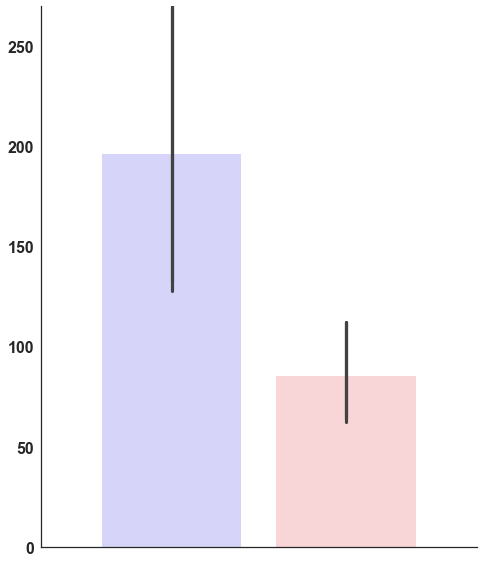

In [50]:
pd.DataFrame(columns=['Ferritin', 'Group'])
fc = pd.DataFrame(Ferr_C)
fp = pd.DataFrame(Ferr_P)
fc['group']   = 'Controls'
fp['group']   = 'Patients'
FERR =pd.concat([fc,fp])
#xpal = ["#1300ff", "#87d6e9"]
xpal =['#b5b8ff','#ffb3b9']
xpal= ['#d0cfff', '#fecfd0']


fig, ax = plt.subplots(1)
fig.set_size_inches([7,8])
g = sns.barplot(x="group", y="CLN_Ferritin", data=FERR,  palette=['b', 'r'])
g = sns.barplot(x="group", y="CLN_Ferritin", data=FERR,  palette=xpal)
plt.xlim(-0.75, 1.75)
plt.ylim(0,270)
# Finalize the plot
sns.despine(bottom=False)
#plt.setp(fig.axes, yticks=[])
plt.setp(fig.axes, xticks=[])
ax.tick_params(axis='y', labelsize=15)
plt.tight_layout(h_pad=3)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=16, weight='bold')
#fig.savefig(os.path.join(save_fig_dir,'FERR_comparison.png'), bbox_inches='tight', transparent = 1, dpi = 500)